# Importing necessary packages

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch, os, shutil, Augmentor
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models

# Getting the GPU if one can be found
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Import the images with their labels & Data splitting

### Importing the datasets as DataFrames

In [7]:
# Import the full training dataset as a DataFrame with the image names and labels
ahe_full_train_df = pd.DataFrame({'image': [], 'label': []})
for item_name in os.listdir('full_training_images'):
    if os.path.isdir(os.path.join('full_training_images', item_name)): # Making sure to get the names of directories only
        for file_name in os.listdir(os.path.join('full_training_images', item_name)):
            if file_name.endswith('.jpg'): # Making sure to get images only
                ahe_full_train_df.loc[len(ahe_full_train_df)] = [file_name, item_name]

# Import the testing dataset as a DataFrame with the image names and labels
ahe_test_df = pd.DataFrame({'image': [], 'label': []})
for item_name in os.listdir('test'):
    if os.path.isdir(os.path.join('test', item_name)): # Making sure to get the names of directories only
        for file_name in os.listdir(os.path.join('test', item_name)):
            if file_name.endswith('.jpg'): # Making sure to get images only
                ahe_test_df.loc[len(ahe_test_df)] = [file_name, item_name]

### Checking the class distribution in the datasets

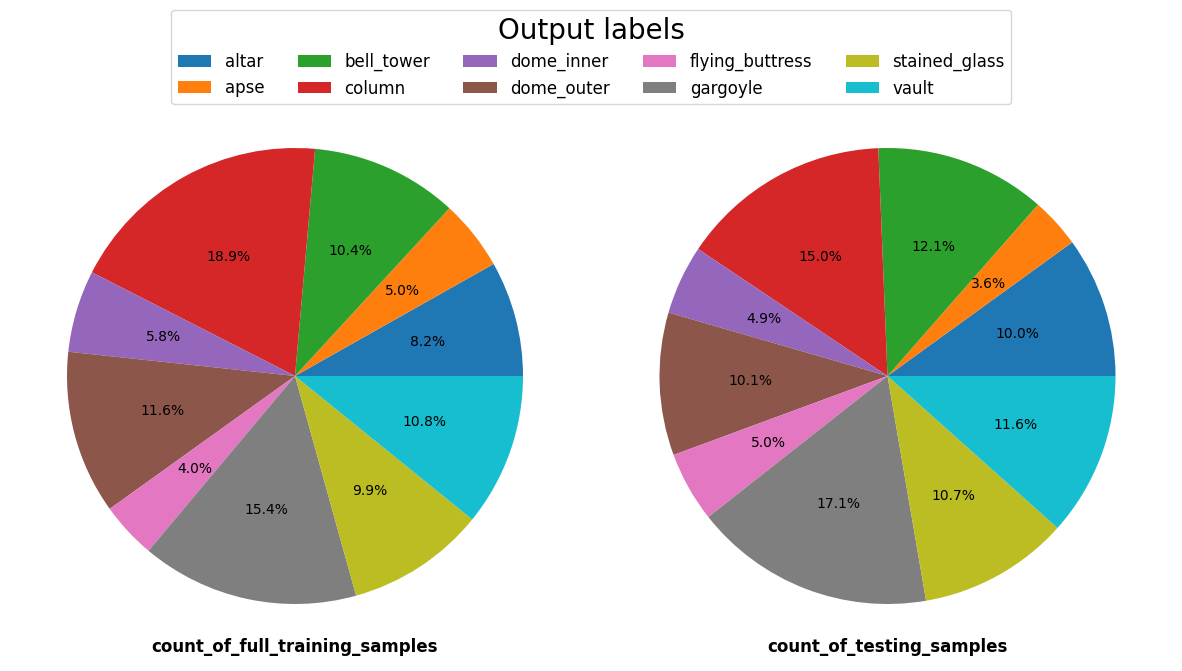

In [95]:
from matplotlib.patches import Patch
import matplotlib

category_count = pd.DataFrame({
    'label': np.unique(ahe_full_train_df['label']),
    'count_of_full_training_samples': np.unique(ahe_full_train_df['label'], return_counts = True)[1],
    'count_of_testing_samples': np.unique(ahe_test_df['label'], return_counts = True)[1]})

colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color']
axes = category_count[['count_of_full_training_samples', 'count_of_testing_samples']].plot(
    kind = 'pie', labels = None, autopct='%.1f%%', colors = colors,
    figsize = (12, 6), subplots = True, legend = False)

# extract the figure object
fig = axes[0].get_figure()

# Decorate the label
for ax in axes.flat:
    yl = ax.get_ylabel()
    ax.set_ylabel(yl, rotation = 0, fontsize = 12, fontweight = 'bold')
    ax.yaxis.set_label_coords(0.5, 0.01)
    
# create the legend
legend_elements = [Patch(fc = c, label = l) for c, l in zip(colors, category_count['label'])]
fig.legend(handles = legend_elements, title = "Output labels", loc = (0.15, 1.5), title_fontsize = 20,
           ncol = 5, fontsize = 12, borderaxespad = 0, bbox_to_anchor = (0., 0.8, 1, .102), frameon = True)

fig.tight_layout()

### Data Splitting on the full training dataset

In [98]:
# Splitting the full-training data into training and validation sets
ahe_train_df, ahe_val_df = train_test_split(
    ahe_full_train_df, test_size = 0.15, shuffle = True, random_state = 96, stratify = ahe_full_train_df['label'])

In [ ]:
# Create a folder for the training and validation data as well as for each architectural category
for arch_class in ahe_train_df['label'].unique():
    os.makedirs(os.path.join('train', arch_class))
    os.makedirs(os.path.join('val', arch_class))

In [ ]:
# Copy the images to the training folder of their corresponding category
for index, row in ahe_train_df.iterrows():
    shutil.copy2(src = os.path.join("full_training_images", row['label'], row['image']),
                 dst = os.path.join("train", row['label'], row['image']))
    
# Do the same thing for the validation images
for index, row in ahe_val_df.iterrows():
    shutil.copy2(src = os.path.join("full_training_images", row['label'], row['image']),
                 dst = os.path.join("val", row['label'], row['image']))

# Perform image augmentation to handle class imbalance

There is a significant imbalance in the distribution of samples across the ten output labels. That could impede the training process and produce misleading results for model performance evaluation.

In [ ]:
train_category_counts = ahe_train_df['label'].value_counts()
train_category_counts

label
column             1627
gargoyle           1328
dome_outer          999
vault               932
bell_tower          898
stained_glass       848
altar               704
dome_inner          501
apse                429
flying_buttress     344
Name: count, dtype: int64

Therefore, image augmentation is used to add more samples to the classes that are not 'column' so that the number of samples in each class would be equal to 1627. Image augmentation techniques include flipping, rotation, skewing, histogram equalisation, and adjustment of contrast, brightness, and color space. The augmented images are put in the folders of their corresponding architectural category in the 'train' folder.

In [ ]:
for category in ahe_train_df['label'].unique():
    if train_category_counts[category] < train_category_counts.max():
        augmentor_pipeline = Augmentor.Pipeline(os.path.join("train", category))
        augmentor_pipeline.flip_left_right(probability = 0.7)
        augmentor_pipeline.skew_tilt(probability = 0.3, magnitude = 0.3)
        augmentor_pipeline.random_contrast(probability = 0.3, min_factor = 0.65, max_factor = 0.85)
        augmentor_pipeline.random_contrast(probability = 0.7, min_factor = 1.2, max_factor = 1.5)
        augmentor_pipeline.random_color(probability = 0.3, min_factor = 0.65, max_factor = 0.85)
        augmentor_pipeline.random_color(probability = 0.7, min_factor = 1.2, max_factor = 1.4)
        augmentor_pipeline.random_brightness(probability = 0.5, min_factor = 0.75, max_factor = 0.85)
        augmentor_pipeline.random_brightness(probability = 0.5, min_factor = 1.2, max_factor = 1.3)
        augmentor_pipeline.histogram_equalisation(probability = 0.7)
        augmentor_pipeline.sample(train_category_counts.max() - train_category_counts[category])

        # Copy the augmented images to the main directory of their corresponding category
        for augmented_image in os.listdir(os.path.join("train", category, 'output')):
            shutil.copy2(src = os.path.join("train", category, 'output', augmented_image),
                         dst = os.path.join("train", category))
            
        # Delete the old directory of the augmented images
        shutil.rmtree(os.path.join("train", category, 'output'))

Initialised with 1328 image(s) found.
Output directory set to train/gargoyle/output.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x146CFFB80>: 100%|██████████| 299/299 [00:00<00:00, 881.82 Samples/s]


Initialised with 999 image(s) found.
Output directory set to train/dome_outer/output.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x146C22310>: 100%|██████████| 628/628 [00:00<00:00, 809.10 Samples/s]


Initialised with 704 image(s) found.
Output directory set to train/altar/output.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x146DC92B0>: 100%|██████████| 923/923 [00:00<00:00, 961.51 Samples/s] 


Initialised with 429 image(s) found.
Output directory set to train/apse/output.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x147A01AC0>: 100%|██████████| 1198/1198 [00:01<00:00, 1012.56 Samples/s]


Initialised with 848 image(s) found.
Output directory set to train/stained_glass/output.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x146B71940>: 100%|██████████| 779/779 [00:00<00:00, 988.30 Samples/s] 


Initialised with 501 image(s) found.
Output directory set to train/dome_inner/output.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x146D59070>: 100%|██████████| 1126/1126 [00:01<00:00, 1043.60 Samples/s]


Initialised with 932 image(s) found.
Output directory set to train/vault/output.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x146D09BE0>: 100%|██████████| 695/695 [00:00<00:00, 1140.76 Samples/s]


Initialised with 898 image(s) found.
Output directory set to train/bell_tower/output.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x146C392B0>: 100%|██████████| 729/729 [00:00<00:00, 945.07 Samples/s] 


Initialised with 344 image(s) found.
Output directory set to train/flying_buttress/output.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x146D90670>: 100%|██████████| 1283/1283 [00:01<00:00, 1041.73 Samples/s]


# Function to train and validate a model

In [ ]:
from sklearn.metrics import accuracy_score
from copy import deepcopy

def train_and_validate_model(model, criterion, optim, epochs, train_loader, val_loader, device, print_log: bool):
    """This function is to train a model on the training data and then validate it on validation data
    at the same time so that not only the validation scores could be obtained but a training log could
    also be produced. For each epoch, the training loss, training accuracy, validation loss, validation
    accuracy, and the highest accuracy score reached are recorded for the training log."""

    training_log = pd.DataFrame({'epoch': [], 'training_loss' : [], 'training_accuracy': [], 'validation_loss': [],
                                 'validation_accuracy': [], 'best_validation_accuracy_reached': []})
    best_val_accuracy_reached = 0

    for epoch in range(epochs):
        # Training the model on the training set
        total_train_loss = 0
        y_train_true, y_train_pred = [], []

        model.train() # Set the model to training mode
        for train_inputs, train_labels in train_loader:
            # get the training inputs and labels in device
            train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)

            optim.zero_grad()
            outputs = model(train_inputs)

            _, predicted_class = torch.max(outputs.data, 1)
            y_train_true.extend(train_labels.cpu().numpy())
            y_train_pred.extend(predicted_class.cpu().numpy())

            current_batch_train_loss = criterion(outputs, train_labels)
            total_train_loss += current_batch_train_loss.item() # Incrementing the total training loss of the current epoch
            current_batch_train_loss.backward()
            optim.step()

        train_loss = total_train_loss / len(train_loader) # Total accumulated loss divided by the number of batches
        train_accuracy = accuracy_score(y_true = y_train_true, y_pred = y_train_pred)

        # Evaluating on the validation set
        total_val_loss = 0
        y_val_true, y_val_pred = [], []

        model.eval() # Set the model to evaluation mode
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                # get the validation inputs and labels in device
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                outputs = model(val_inputs)

                current_batch_val_loss = criterion(outputs, val_labels)
                total_val_loss += current_batch_val_loss.item() # Incrementing the total validation loss of the current epoch
                _, predicted_class = torch.max(outputs.data, 1)
                y_val_true.extend(val_labels.cpu().numpy())
                y_val_pred.extend(predicted_class.cpu().numpy())

        val_loss = total_val_loss / len(val_loader) # Total accumulated loss divided by the number of batches
        val_accuracy = accuracy_score(y_true = y_val_true, y_pred = y_val_pred)

        # Save the model weights that returned the best validation accuracy
        if val_accuracy > best_val_accuracy_reached:
            best_val_accuracy_reached = val_accuracy
            torch.save(f = "best_model.pt", obj = deepcopy(model.state_dict()))

        # Display the training log if needed
        if print_log == True:
            print('Epoch:', epoch+1, '| Training Loss:', round(train_loss, 3),
                  '| Training Accuracy:', round(train_accuracy, 3),
                  '| Validation Loss:', round(val_loss, 3),
                  '| Validation Accuracy:', round(val_accuracy, 3),
                  '| Best Validation Accuracy Reached:', round(best_val_accuracy_reached, 3),
                  sep = " ")

        # Updating the training log dataframe to return at the end
        training_log.loc[len(training_log)] = [epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy, best_val_accuracy_reached]

    return training_log

# Get the datasets in the Pytorch-compatible format

In [ ]:
# Preparing the transformation techniques
transform_compose = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

# Using DataLoader to get the training, validation, and testing datasets ready
ahe_train_ds = datasets.ImageFolder('train', transform = transform_compose)
ahe_train = torch.utils.data.DataLoader(
    ahe_train_ds, batch_size = 64, shuffle = True, num_workers = 2)

ahe_val_ds = datasets.ImageFolder('val', transform = transform_compose)
ahe_val = torch.utils.data.DataLoader(
    ahe_val_ds, batch_size = 64, shuffle = True, num_workers = 2)

ahe_test_ds = datasets.ImageFolder('test', transform = transform_compose)
ahe_test = torch.utils.data.DataLoader(
    ahe_test_ds, batch_size = 64, shuffle = True, num_workers = 2)

# ===== A Custom CNN model

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv2d_stack = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, stride = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, stride = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 36864, out_features = 1024),
            nn.ReLU(),
            nn.Linear(in_features = 1024, out_features = 128),
            nn.ReLU()
        )

        self.output = nn.Linear(in_features = 128, out_features = 10) # corresponding to 10 output classes

    def forward(self, x):
        x = self.conv2d_stack(x)
        x = self.linear(x)
        x = self.output(x)
        return x

In [ ]:
custom_cnn = CustomCNN()
custom_cnn.to(device)
print(custom_cnn) # Displaying the model architecture

CustomCNN(
  (conv2d_stack): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=36864, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=128, bias=True)
    (4): ReLU()
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
hyperparams_space = {'epochs': [10, 15, 20],
                     'lr': [0.0001, 0.001, 0.01],
                     'optimiser': ['SGD', 'Adam', 'RMSprop']}

custom_cnn_hyperparams_tune_result = pd.DataFrame(
    {'max_epochs': [], 'learning_rate': [], 'optimiser': [], 'best_validation_accuracy_reached': []})

for epochs in hyperparams_space['epochs']:
    for lr in hyperparams_space['lr']:
        for optimiser in hyperparams_space['optimiser']:
            torch.manual_seed(99) # For reproducibility purpose
            my_custom_cnn = CustomCNN()
            my_custom_cnn.to(device)
            my_criterion = nn.CrossEntropyLoss()

            if optimiser == 'SGD':
                my_optimiser = optim.SGD(params = my_custom_cnn.parameters(), lr = lr)
            if optimiser == 'Adam':
                my_optimiser = optim.Adam(params = my_custom_cnn.parameters(), lr = lr)
            if optimiser == 'RMSprop':
                my_optimiser = optim.RMSprop(params = my_custom_cnn.parameters(), lr = lr)

            training_log_df = train_and_validate_model(
                model = my_custom_cnn, optim = my_optimiser, epochs = epochs, criterion = my_criterion,
                train_loader = ahe_train, val_loader = ahe_val, device = device, print_log = False)

            best_val_accuracy_reached = training_log_df['best_validation_accuracy_reached'].values[-1]

            custom_cnn_hyperparams_tune_result.loc[len(custom_cnn_hyperparams_tune_result)] = [
                epochs, lr, optimiser, best_val_accuracy_reached]

In [ ]:
# Sorting the tuning results according to the best_validation_accuracy_reached
custom_cnn_hyperparams_tune_result.sort_values(
    by = 'best_validation_accuracy_reached', ascending = False, inplace = True)
custom_cnn_hyperparams_tune_result.reset_index(drop = True, inplace = True)

# Show the top results
custom_cnn_hyperparams_tune_result.head(10)


,max_epochs,learning_rate,optimiser,best_validation_accuracy_reached
0,15,0.0001,RMSprop,0.731579
1,20,0.0001,RMSprop,0.730921
2,20,0.0010,Adam,0.726605
3,15,0.0010,Adam,0.723632
4,10,0.0001,RMSprop,0.716974
5,20,0.0001,Adam,0.713026
6,10,0.0010,RMSprop,0.709737
7,10,0.0010,Adam,0.709737
8,20,0.0010,RMSprop,0.708421
9,15,0.0001,Adam,0.707105


In [ ]:
print("The best hyperparameter setting for the custom CNN model is:\n",
      custom_cnn_hyperparams_tune_result.loc[0], sep = "")

The best hyperparameter setting for the custom CNN model is:
max_epochs                                15
learning_rate                         0.0001
optimiser                            RMSprop
best_validation_accuracy_reached    0.731579
Name: 0, dtype: object


# ===== VGG16 model

In [ ]:
# Modifying the last layer of VGG16 to have 10 output classes
my_vgg16 = models.vgg16()
my_vgg16.classifier[-1] = nn.Linear(in_features = my_vgg16.classifier[-1].in_features, out_features = 10)
print(my_vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
vgg16_hyperparams_tune_result = pd.DataFrame(
    {'max_epochs': [], 'learning_rate': [], 'optimiser': [], 'best_validation_accuracy_reached': []})

for epochs in hyperparams_space['epochs']:
    for lr in hyperparams_space['lr']:
        for optimiser in hyperparams_space['optimiser']:
            torch.manual_seed(99) # For reproducibility purpose
            my_vgg16 = models.vgg16()
            my_vgg16.classifier[-1] = nn.Linear(in_features = my_vgg16.classifier[-1].in_features, out_features = 10)
            my_vgg16.to(device)
            my_criterion = nn.CrossEntropyLoss()

            if optimiser == 'SGD':
                my_optimiser = optim.SGD(params = my_vgg16.parameters(), lr = lr)
            if optimiser == 'Adam':
                my_optimiser = optim.Adam(params = my_vgg16.parameters(), lr = lr)
            if optimiser == 'RMSprop':
                my_optimiser = optim.RMSprop(params = my_vgg16.parameters(), lr = lr)

            training_log_df = train_and_validate_model(
                model = my_vgg16, optim = my_optimiser, epochs = epochs, criterion = my_criterion,
                train_loader = ahe_train, val_loader = ahe_val, device = device, print_log = False)

            best_val_accuracy_reached = training_log_df['best_validation_accuracy_reached'].values[-1]

            vgg16_hyperparams_tune_result.loc[len(vgg16_hyperparams_tune_result)] = [
                epochs, lr, optimiser, best_val_accuracy_reached]

In [ ]:
# Sorting the tuning results according to the best_validation_accuracy_reached
vgg16_hyperparams_tune_result.sort_values(
    by = 'best_validation_accuracy_reached', ascending = False, inplace = True)
vgg16_hyperparams_tune_result.reset_index(drop = True, inplace = True)

# Show the top results
vgg16_hyperparams_tune_result.head(10)

,max_epochs,learning_rate,optimiser,best_validation_accuracy_reached
0,20,0.0001,Adam,0.813158
1,15,0.0001,Adam,0.802632
2,15,0.0001,RMSprop,0.796579
3,10,0.0001,Adam,0.792518
4,20,0.0001,RMSprop,0.791368
5,10,0.0001,RMSprop,0.783579
6,20,0.0010,RMSprop,0.753921
7,15,0.0010,RMSprop,0.750789
8,15,0.0010,SGD,0.722342
9,10,0.0010,RMSprop,0.720789


In [ ]:
print("The best hyperparameter setting for the VGG16 model is:\n",
      vgg16_hyperparams_tune_result.loc[0], sep = "")

The best hyperparameter setting for the VGG16 model is:
max_epochs                                20
learning_rate                         0.0001
optimiser                               Adam
best_validation_accuracy_reached    0.813158
Name: 0, dtype: object


# ===== VGG19 model

In [ ]:
# Modifying the last layer of VGG19 to have 10 output classes
my_vgg19 = models.vgg19()
my_vgg19.classifier[-1] = nn.Linear(in_features = my_vgg19.classifier[-1].in_features, out_features = 10)
# print(my_vgg19) - not printing to save space

In [ ]:
vgg19_hyperparams_tune_result = pd.DataFrame(
    {'max_epochs': [], 'learning_rate': [], 'optimiser': [], 'best_validation_accuracy_reached': []})

for epochs in hyperparams_space['epochs']:
    for lr in hyperparams_space['lr']:
        for optimiser in hyperparams_space['optimiser']:
            torch.manual_seed(99) # For reproducibility purpose
            my_vgg19 = models.vgg19()
            my_vgg19.classifier[-1] = nn.Linear(in_features = my_vgg19.classifier[-1].in_features, out_features = 10)
            my_vgg19.to(device)
            my_criterion = nn.CrossEntropyLoss()

            if optimiser == 'SGD':
                my_optimiser = optim.SGD(params = my_vgg19.parameters(), lr = lr)
            if optimiser == 'Adam':
                my_optimiser = optim.Adam(params = my_vgg19.parameters(), lr = lr)
            if optimiser == 'RMSprop':
                my_optimiser = optim.RMSprop(params = my_vgg19.parameters(), lr = lr)

            training_log_df = train_and_validate_model(
                model = my_vgg19, optim = my_optimiser, epochs = epochs, criterion = my_criterion,
                train_loader = ahe_train, val_loader = ahe_val, device = device, print_log = False)

            best_val_accuracy_reached = training_log_df['best_validation_accuracy_reached'].values[-1]

            vgg19_hyperparams_tune_result.loc[len(vgg19_hyperparams_tune_result)] = [
                epochs, lr, optimiser, best_val_accuracy_reached]

In [ ]:
# Sorting the tuning results according to the best_validation_accuracy_reached
vgg19_hyperparams_tune_result.sort_values(
    'best_validation_accuracy_reached', ascending = False, inplace = True)
vgg19_hyperparams_tune_result.reset_index(drop = True, inplace = True)

# Show the top results
vgg19_hyperparams_tune_result.head(10)

,max_epochs,learning_rate,optimiser,best_validation_accuracy_reached
0,15,0.0001,Adam,0.820368
1,20,0.0001,Adam,0.816815
2,20,0.0001,RMSprop,0.809473
3,10,0.0001,Adam,0.808905
4,15,0.0001,RMSprop,0.799342
5,15,0.0010,Adam,0.780136
6,10,0.0001,RMSprop,0.779517
7,20,0.0010,Adam,0.778186
8,20,0.0010,RMSprop,0.751465
9,15,0.0100,SGD,0.738605


In [ ]:
print("The best hyperparameter setting for the VGG19 model is:\n",
      vgg19_hyperparams_tune_result.loc[0], sep = "")

The best hyperparameter setting for the VGG19 model is:
max_epochs                                15
learning_rate                         0.0001
optimiser                               Adam
best_validation_accuracy_reached    0.820368
Name: 0, dtype: object


# ===== ResNet-34 model

In [2]:
my_resnet34 = models.resnet34()
my_resnet34.fc = nn.Linear(in_features = my_resnet34.fc.in_features, out_features = 10)
print(my_resnet34) # Displaying the model architecture

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet34_hyperparams_tune_result = pd.DataFrame(
    {'max_epochs': [], 'learning_rate': [], 'optimiser': [], 'best_validation_accuracy_reached': []})

for epochs in hyperparams_space['epochs']:
    for lr in hyperparams_space['lr']:
        for optimiser in hyperparams_space['optimiser']:
            torch.manual_seed(99) # For reproducibility purpose
            my_resnet34 = models.resnet34()
            my_resnet34.fc = nn.Linear(in_features = my_resnet34.fc.in_features, out_features = 10)
            my_resnet34.to(device)
            my_criterion = nn.CrossEntropyLoss()

            if optimiser == 'SGD':
                my_optimiser = optim.SGD(params = my_resnet34.parameters(), lr = lr)
            if optimiser == 'Adam':
                my_optimiser = optim.Adam(params = my_resnet34.parameters(), lr = lr)
            if optimiser == 'RMSprop':
                my_optimiser = optim.RMSprop(params = my_resnet34.parameters(), lr = lr)

            training_log_df = train_and_validate_model(
                model = my_resnet34, optim = my_optimiser, epochs = epochs, criterion = my_criterion,
                train_loader = ahe_train, val_loader = ahe_val, device = device, print_log = False)

            best_val_accuracy_reached = training_log_df['best_validation_accuracy_reached'].values[-1]

            resnet34_hyperparams_tune_result.loc[len(resnet34_hyperparams_tune_result)] = [
                epochs, lr, optimiser, best_val_accuracy_reached]

In [ ]:
# Sorting the tuning results according to the best_validation_accuracy_reached
resnet34_hyperparams_tune_result.sort_values(
    'best_validation_accuracy_reached', ascending = False, inplace = True)

# Show the top results
resnet34_hyperparams_tune_result.reset_index(drop = True, inplace = True)
resnet34_hyperparams_tune_result.head(10)

,max_epochs,learning_rate,optimiser,best_validation_accuracy_reached
0,20,0.0010,Adam,0.858816
1,20,0.0010,RMSprop,0.857289
2,15,0.0010,Adam,0.856632
3,15,0.0010,RMSprop,0.851053
4,15,0.0001,Adam,0.839868
5,10,0.0010,Adam,0.836632
6,10,0.0010,RMSprop,0.829728
7,15,0.0001,Adam,0.829163
8,20,0.0001,Adam,0.828711
9,20,0.0001,RMSprop,0.826073


In [4]:
print("The best hyperparameter setting for the ResNet-34 model is:\n",
      resnet34_hyperparams_tune_result.loc[0], sep = "")

The best hyperparameter setting for the ResNet-34 model is:
max_epochs                                20
learning_rate                          0.001
optimiser                               Adam
best_validation_accuracy_reached    0.858816
Name: 0, dtype: object


# ===== ResNet-50 model

In [ ]:
my_resnet50 = models.resnet50()
my_resnet50.fc = nn.Linear(in_features = my_resnet50.fc.in_features, out_features = 10)
# print(my_resnet50) - not printing to save space

In [ ]:
resnet50_hyperparams_tune_result = pd.DataFrame(
    {'max_epochs': [], 'learning_rate': [], 'optimiser': [], 'best_validation_accuracy_reached': []})

for epochs in hyperparams_space['epochs']:
    for lr in hyperparams_space['lr']:
        for optimiser in hyperparams_space['optimiser']:
            torch.manual_seed(99) # For reproducibility purpose
            my_resnet50 = models.resnet50()
            my_resnet50.fc = nn.Linear(in_features = my_resnet50.fc.in_features, out_features = 10)
            my_resnet50.to(device)
            my_criterion = nn.CrossEntropyLoss()

            if optimiser == 'SGD':
                my_optimiser = optim.SGD(params = my_resnet50.parameters(), lr = lr)
            if optimiser == 'Adam':
                my_optimiser = optim.Adam(params = my_resnet50.parameters(), lr = lr)
            if optimiser == 'RMSprop':
                my_optimiser = optim.RMSprop(params = my_resnet50.parameters(), lr = lr)

            training_log_df = train_and_validate_model(
                model = my_resnet50, optim = my_optimiser, epochs = epochs, criterion = my_criterion,
                train_loader = ahe_train, val_loader = ahe_val, device = device, print_log = False)

            best_val_accuracy_reached = training_log_df['best_validation_accuracy_reached'].values[-1]

            resnet50_hyperparams_tune_result.loc[len(resnet50_hyperparams_tune_result)] = [
                epochs, lr, optimiser, best_val_accuracy_reached]

In [ ]:
# Sorting the tuning results according to the best_validation_accuracy_reached
resnet50_hyperparams_tune_result.sort_values(
    'best_validation_accuracy_reached', ascending = False, inplace = True)

# Show the top results
resnet50_hyperparams_tune_result.reset_index(drop = True, inplace = True)
resnet50_hyperparams_tune_result.head(10)

,max_epochs,learning_rate,optimiser,best_validation_accuracy_reached
0,15,0.0010,RMSprop,0.869712
1,20,0.0010,Adam,0.867114
2,20,0.0010,Adam,0.862176
3,15,0.0010,RMSprop,0.861518
4,15,0.0001,Adam,0.859431
5,10,0.0010,Adam,0.856003
6,10,0.0010,RMSprop,0.849901
7,15,0.0001,Adam,0.839017
8,20,0.0001,Adam,0.838347
9,20,0.0001,RMSprop,0.836403


In [ ]:
print("The best hyperparameter setting for the ResNet-50 model is:\n",
      resnet50_hyperparams_tune_result.loc[0], sep = "")

The best hyperparameter setting for the ResNet-50 model is:
max_epochs                                15
learning_rate                          0.001
optimiser                            RMSprop
best_validation_accuracy_reached    0.869712
Name: 0, dtype: object


# ===== DenseNet-121 model

In [ ]:
my_densenet121 = models.densenet121()
my_densenet121.classifier = nn.Linear(in_features = my_densenet121.classifier.in_features, out_features = 10)
# print(my_densenet121) - not printing to save space

In [ ]:
densenet121_hyperparams_tune_result = pd.DataFrame(
    {'max_epochs': [], 'learning_rate': [], 'optimiser': [], 'best_validation_accuracy_reached': []})

for epochs in hyperparams_space['epochs']:
    for lr in hyperparams_space['lr']:
        for optimiser in hyperparams_space['optimiser']:
            torch.manual_seed(99) # For reproducibility purpose
            my_densenet121 = models.densenet121()
            my_densenet121.classifier = nn.Linear(in_features = my_densenet121.classifier.in_features, out_features = 10)
            my_densenet121.to(device)
            my_criterion = nn.CrossEntropyLoss()

            if optimiser == 'SGD':
                my_optimiser = optim.SGD(params = my_densenet121.parameters(), lr = lr)
            if optimiser == 'Adam':
                my_optimiser = optim.Adam(params = my_densenet121.parameters(), lr = lr)
            if optimiser == 'RMSprop':
                my_optimiser = optim.RMSprop(params = my_densenet121.parameters(), lr = lr)

            training_log_df = train_and_validate_model(
                model = my_densenet121, optim = my_optimiser, epochs = epochs, criterion = my_criterion,
                train_loader = ahe_train, val_loader = ahe_val, device = device, print_log = False)

            best_val_accuracy_reached = training_log_df['best_validation_accuracy_reached'].values[-1]

            densenet121_hyperparams_tune_result.loc[len(densenet121_hyperparams_tune_result)] = [
                epochs, lr, optimiser, best_val_accuracy_reached]

In [ ]:
# Sorting the tuning results according to the best_validation_accuracy_reached
resnet50_hyperparams_tune_result.sort_values(
    'best_validation_accuracy_reached', ascending = False, inplace = True)
resnet50_hyperparams_tune_result.reset_index(drop = True, inplace = True)

# Show the top results
resnet50_hyperparams_tune_result.head(10)


,max_epochs,learning_rate,optimiser,best_validation_accuracy_reached
0,20,0.0010,Adam,0.915816
1,15,0.0010,Adam,0.904732
2,20,0.0010,RMSprop,0.898816
3,10,0.0010,Adam,0.894184
4,15,0.0010,RMSprop,0.879605
5,15,0.0001,Adam,0.874184
6,10,0.0010,RMSprop,0.873600
7,20,0.0001,Adam,0.871184
8,20,0.0001,SGD,0.867131
9,15,0.0001,RMSprop,0.869705


In [ ]:
print("The best hyperparameter setting for the DenseNet-121 model is:\n",
      densenet121_hyperparams_tune_result.loc[0], sep = "")

The best hyperparameter setting for the DenseNet-121 model is:
max_epochs                                20
learning_rate                          0.001
optimiser                               Adam
best_validation_accuracy_reached    0.915816
Name: 0, dtype: object


# Getting the best-performing model

Based on the best validation scores reached by each model with their optimised hyperparameters, the DenseNet-121 appears to show the best performance, so it is nominated for the final evaluation stage on the testing data. Below is some information about the training log of the chosen model with its optimised hyperparameter setting.

In [ ]:
# Train the DenseNet-121 model again to display the training log at every epoch

torch.manual_seed(99) # For reproducibility purpose
my_densenet121 = models.densenet121()
my_densenet121.classifier = nn.Linear(in_features = my_densenet121.classifier.in_features, out_features = 10)
my_densenet121.to(device)
my_criterion = nn.CrossEntropyLoss()
my_optimiser = optim.Adam(params = my_densenet121.parameters(), lr = 0.001)

my_densenet121_training_log_df = train_and_validate_model(
    model = my_densenet121, epochs = 20, optim = my_optimiser, criterion = my_criterion,
    train_loader = ahe_train, val_loader = ahe_val, device = device, print_log = True)

Epoch: 1 | Training Loss: 1.321 | Training Accuracy: 0.53 | Validation Loss: 0.878 | Validation Accuracy: 0.705 | Best Validation Accuracy Reached: 0.705
Epoch: 2 | Training Loss: 0.836 | Training Accuracy: 0.713 | Validation Loss: 0.792 | Validation Accuracy: 0.733 | Best Validation Accuracy Reached: 0.733
Epoch: 3 | Training Loss: 0.61 | Training Accuracy: 0.79 | Validation Loss: 0.616 | Validation Accuracy: 0.801 | Best Validation Accuracy Reached: 0.801
Epoch: 4 | Training Loss: 0.452 | Training Accuracy: 0.848 | Validation Loss: 0.543 | Validation Accuracy: 0.823 | Best Validation Accuracy Reached: 0.823
Epoch: 5 | Training Loss: 0.357 | Training Accuracy: 0.88 | Validation Loss: 0.434 | Validation Accuracy: 0.861 | Best Validation Accuracy Reached: 0.861
Epoch: 6 | Training Loss: 0.282 | Training Accuracy: 0.903 | Validation Loss: 0.406 | Validation Accuracy: 0.877 | Best Validation Accuracy Reached: 0.877
Epoch: 7 | Training Loss: 0.226 | Training Accuracy: 0.922 | Validation Lo

In [ ]:
# Displaying the training log in a DataFrame
my_densenet121_training_log_df

,epoch,training_loss,training_accuracy,validation_loss,validation_accuracy,best_validation_accuracy_reached
0,1,1.321195,0.530055,0.878382,0.704605,0.704605
1,2,0.835899,0.712784,0.791794,0.732895,0.732895
2,3,0.610347,0.789859,0.616284,0.800658,0.800658
3,4,0.451798,0.848125,0.542962,0.823026,0.823026
4,5,0.357312,0.879594,0.433569,0.860526,0.860526
5,6,0.281543,0.903073,0.405582,0.876974,0.876974
6,7,0.225542,0.921942,0.398775,0.881132,0.881132
7,8,0.193483,0.934235,0.373044,0.887053,0.887053
8,9,0.158784,0.946343,0.368320,0.895658,0.895658
9,10,0.125490,0.959557,0.370277,0.893998,0.895658


==> The best validation accuracy was achieved at the end of epoch 18, so the weights recorded at this epoch were saved for the DenseNet-121 model.

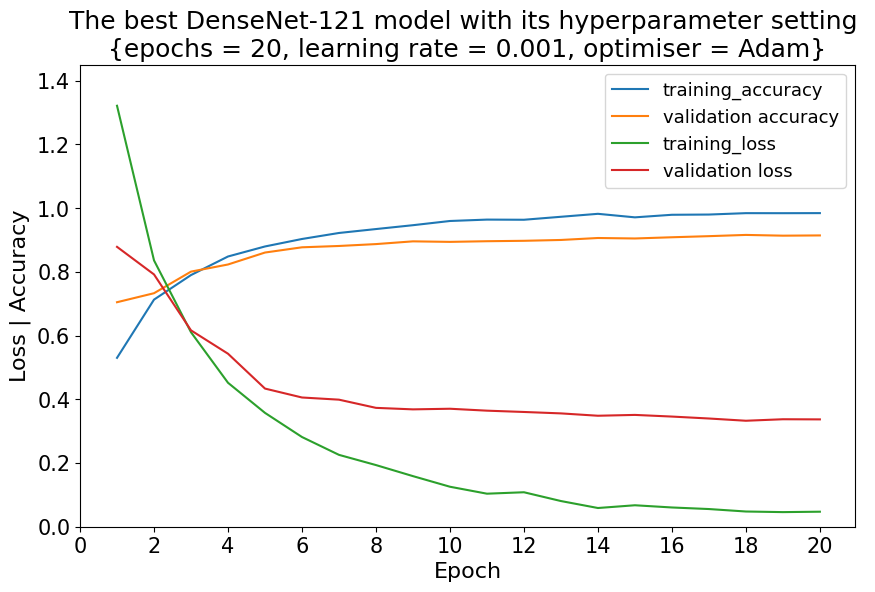

In [11]:
import matplotlib.pyplot as plt

# Plotting the learning curves of the chosen model (DenseNet-121)
plt.figure(figsize = (10, 6))
plt.plot(my_densenet121_training_log_df['epoch'], my_densenet121_training_log_df['training_accuracy'], label = "training_accuracy")
plt.plot(my_densenet121_training_log_df['epoch'], my_densenet121_training_log_df['validation_accuracy'], label = "validation accuracy")
plt.plot(my_densenet121_training_log_df['epoch'], my_densenet121_training_log_df['training_loss'], label = "training_loss")
plt.plot(my_densenet121_training_log_df['epoch'], my_densenet121_training_log_df['validation_loss'], label = "validation loss")
plt.legend()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss | Accuracy', fontsize = 16)
plt.xticks(np.arange(0, 21, 2), fontsize = 15)
plt.yticks(np.arange(0, 1.5, 0.2), fontsize = 15)
plt.ylim(0, 1.45)
plt.legend(prop={'size': 13})
plt.title('The best DenseNet-121 model with its hyperparameter setting \n{epochs = 20, learning rate = 0.001, optimiser = Adam}', fontsize = 18)
plt.show()

# Final evaluation of the chosen model (DenseNet-121 after being trained with its optimised hyperparameter setting) on the testing data

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, classification_report

my_densenet121 = models.densenet121()
my_densenet121.classifier = nn.Linear(in_features = my_densenet121.classifier.in_features, out_features = 10)
my_densenet121.load_state_dict(torch.load('best_model.pt'))
my_densenet121.to(device)

y_true, y_pred = [], []
my_densenet121.eval() # Set the model to evaluation mode
with torch.no_grad():
    for test_inputs, test_labels in ahe_test:
        test_inputs = test_inputs.to(device)
        outputs = my_densenet121(test_inputs)
        _, predicted_class = torch.max(outputs, 1)
        y_true.extend(test_labels.numpy())
        y_pred.extend(predicted_class.cpu().numpy())

In [ ]:
print('Recall (macro):', recall_score(y_true = y_true, y_pred = y_pred, average = 'macro'))
print('Recall (weighted):', recall_score(y_true = y_true, y_pred = y_pred, average = 'weighted'))
print('Precision (macro):', precision_score(y_true = y_true, y_pred = y_pred, average = 'macro'))
print('Precision (weighted):', precision_score(y_true = y_true, y_pred = y_pred, average = 'weighted'))
print('F1 (macro):', f1_score(y_true = y_true, y_pred = y_pred, average = 'macro'))
print('F1 (weighted):', f1_score(y_true = y_true, y_pred = y_pred, average = 'weighted'))
print('Accuracy:', accuracy_score(y_true = y_true, y_pred = y_pred))
print('Balanced accuracy:', balanced_accuracy_score(y_true = y_true, y_pred = y_pred))

Recall (macro): 0.8906523174817924
Recall (weighted): 0.9038461538461539
Precision (macro): 0.9017537311164829
Precision (weighted): 0.9051271177484028
F1 (macro): 0.8947532206803104
F1 (weighted): 0.9036959433651827
Accuracy: 0.9038461538461539
Balanced accuracy: 0.8906523174817924


In [ ]:
classification_report(
    y_true = y_true, y_pred = y_pred,
    target_names = ahe_test.dataset.classes
    output_dict = True)

{'altar': {'precision': 0.87248322147651,
  'recall': 0.9285714285714286,
  'f1-score': 0.8996539792387543,
  'support': 140},
 'apse': {'precision': 0.8837209302325582,
  'recall': 0.76,
  'f1-score': 0.8172043010752689,
  'support': 50},
 'bell_tower': {'precision': 0.8787878787878788,
  'recall': 0.8529411764705882,
  'f1-score': 0.8656716417910447,
  'support': 170},
 'column': {'precision': 0.9, 'recall': 0.9, 'f1-score': 0.9, 'support': 210},
 'dome_inner': {'precision': 0.95,
  'recall': 0.8260869565217391,
  'f1-score': 0.8837209302325583,
  'support': 69},
 'dome_outer': {'precision': 0.8972602739726028,
  'recall': 0.9225352112676056,
  'f1-score': 0.9097222222222222,
  'support': 142},
 'flying_buttress': {'precision': 0.8227848101265823,
  'recall': 0.9285714285714286,
  'f1-score': 0.87248322147651,
  'support': 70},
 'gargoyle': {'precision': 0.9065040650406504,
  'recall': 0.9291666666666667,
  'f1-score': 0.9176954732510288,
  'support': 240},
 'stained_glass': {'precis

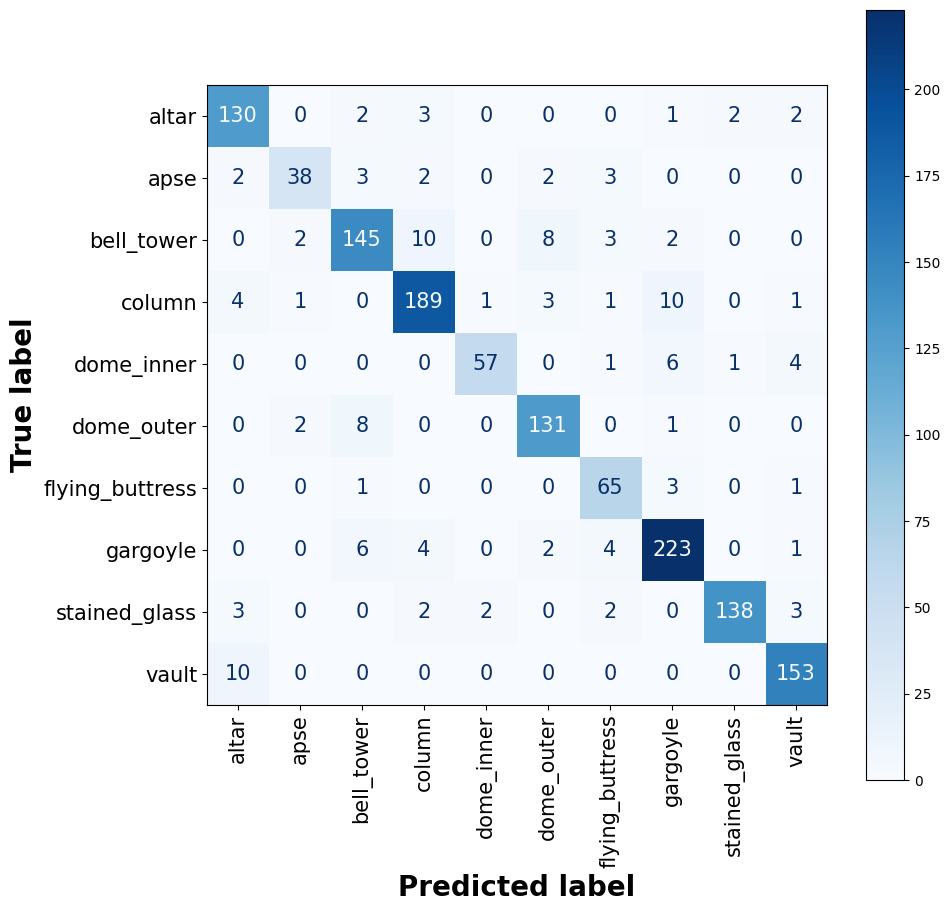

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Displaying a confusion matrix on the testing data
diabetes_test_cf = confusion_matrix(y_true = y_true, y_pred = y_pred)
diabetes_test_cf_disp = ConfusionMatrixDisplay(diabetes_test_cf, display_labels = ahe_test.dataset.classes)
fig, ax = plt.subplots(figsize=(10,10))
diabetes_test_cf_disp.plot(ax = ax, cmap = plt.cm.Blues)
for labels in diabetes_test_cf_disp.text_.ravel():
    labels.set_fontsize(15)
ax.set_xlabel(xlabel = "Predicted label", fontdict = {'size': 20, 'weight': 'bold'})
ax.set_ylabel(ylabel = "True label", fontdict = {'size': 20, 'weight': 'bold'})
plt.xticks(fontsize = 15, rotation = 90)
plt.yticks(fontsize = 15)
plt.show()